In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn import metrics

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

# Set pandas display options so we can read more of the comment text.
pd.set_option('max_colwidth', 300)

import model_bias_analysis

In [2]:
# Print python version
import sys
print(sys.version)

3.6.3 (default, Oct  3 2017, 21:16:13) 
[GCC 7.3.0]


# Load and pre-process Madlibs data

In [3]:
# Read madlibs dataset, convert Label to Booleans
madlibs_df = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')
madlibs_df.loc[madlibs_df.Label == 'BAD', 'Label'] = True
madlibs_df.loc[madlibs_df.Label == 'NOT_BAD', 'Label'] = False
# Needed for AUC metrics to work properly
madlibs_df['Label'] = madlibs_df['Label'].astype(bool)

In [4]:
# Add boolean identity columns, e.g. "hug american" should have True in the "american" column.
madlibs_identity_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')
model_bias_analysis.add_subgroup_columns_from_text(madlibs_df, 'Text', madlibs_identity_terms)
madlibs_df.head()

,Label,Template,Text,id,RockV6_2:TOXICITY,Rock:TOXICITY,lesbian,gay,bisexual,transgender,...,older,young,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed
0,True,verb_adj,murder american,0,0.837852,0.811245,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,verb_adj,respect trans,1,0.066053,0.251806,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,verb_adj,respect homosexual,2,0.188938,0.831167,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,verb_adj,hug mexican,3,0.059981,0.098826,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,verb_adj,kill sikh,4,0.743793,0.888041,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Load and pre-process Civil Comments data

In [5]:
def convert_to_bool_column(df, src_column, dst_column):
    df.loc[df[src_column] >= 0.5, dst_column] = True
    df.loc[df[src_column] < 0.5, dst_column] = False
    # convert NaNs to False
    df.loc[df[src_column].isnull(), dst_column] = False
    # Needed for AUC metrics to work properly
    df[dst_column] = df[dst_column].astype(bool)

In [6]:
# Read Civil Comments dataset, set Label column to be a Boolean toxicity value.
civil_comments_df = pd.read_csv('eval_datasets/civil_comments_scored_prod_models.csv')
convert_to_bool_column(civil_comments_df, 'toxicity', 'Label')

In [7]:
# Convert identity terms to booleans
civil_comments_identity_terms = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual',
    'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian',
    'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black',
    'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability']
for identity in civil_comments_identity_terms:
    convert_to_bool_column(civil_comments_df, identity, identity)
civil_comments_df.head()
    

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,article_id,asian,atheist,bisexual,black,buddhist,christian,...,sexual_explicit,threat,toxicity,toxicity_annotator_count,transgender,white,wow,Rock:TOXICITY,RockV6_2:TOXICITY,Label
0,0,0,0,138380,False,False,False,False,False,False,...,0.000000,0.000000,0.783333,60,False,False,0,0.623230,0.865134,True
1,1,1,1,160937,False,False,False,False,False,False,...,0.000000,0.000000,0.628571,70,False,False,0,0.773702,0.831807,True
2,2,2,2,366992,False,False,False,False,False,False,...,0.028571,0.014286,0.571429,70,False,False,0,0.544393,0.607978,True
3,3,3,3,351749,False,False,False,False,False,False,...,0.000000,0.000000,0.675000,80,False,False,0,0.683339,0.869096,True
4,4,4,4,147521,False,False,False,False,False,False,...,0.000000,0.413333,0.800000,75,False,False,0,0.876304,0.836591,True


In [8]:
# Create another view of the data that is limited to the comments < 100 characters.
civil_comments_short_df = civil_comments_df.loc[civil_comments_df['Text'].str.len() < 100]

# Measure bias

In [9]:
# Calculate bias metrics on each dataset
madlibs_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    madlibs_df,
    madlibs_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')
civil_comments_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    civil_comments_df,
    civil_comments_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')

In [10]:
civil_comments_short_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    civil_comments_short_df,
    civil_comments_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')

value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not 

In [11]:
# Sort bias metrics by weighted pinned AUC
def sort_by_weighted_pinned_auc(bias_metrics):
    bias_metrics['weighted_pinned_auc'] = (
        bias_metrics['Rock:TOXICITY_bnsp_auc'] +
        bias_metrics['Rock:TOXICITY_bpsn_auc'] +
        bias_metrics['Rock:TOXICITY_subgroup_auc']) / 3
    bias_metrics = bias_metrics.sort_values('weighted_pinned_auc', ascending=True)
    return bias_metrics.drop('weighted_pinned_auc', axis=1)

madlibs_bias_metrics = sort_by_weighted_pinned_auc(madlibs_bias_metrics)
civil_comments_bias_metrics = sort_by_weighted_pinned_auc(civil_comments_bias_metrics)
civil_comments_short_bias_metrics = sort_by_weighted_pinned_auc(civil_comments_short_bias_metrics)

In [12]:
civil_comments_short_bias_metrics

,Rock:TOXICITY_bnsp_auc,Rock:TOXICITY_bpsn_auc,Rock:TOXICITY_negative_aeg,Rock:TOXICITY_positive_aeg,Rock:TOXICITY_subgroup_auc,subgroup,subset_size,RockV6_2:TOXICITY_bnsp_auc,RockV6_2:TOXICITY_bpsn_auc,RockV6_2:TOXICITY_negative_aeg,RockV6_2:TOXICITY_positive_aeg,RockV6_2:TOXICITY_subgroup_auc
5,0.980982,0.574538,0.432675,0.104485,0.704905,homosexual_gay_or_lesbian,744,0.925852,0.824474,0.297265,-0.080014,0.766313
21,0.834876,0.913458,0.289680,-0.238645,0.571429,intellectual_or_learning_disability,11,0.816821,0.831456,0.291527,-0.234120,0.535714
4,0.936990,0.727618,0.342242,-0.027559,0.721014,heterosexual,58,0.934071,0.874501,0.211539,-0.189703,0.793478
2,0.924896,0.823160,0.336956,-0.174700,0.740532,transgender,183,0.895946,0.889951,0.269487,-0.178809,0.768658
15,0.945101,0.786177,0.353858,-0.047656,0.766081,black,1056,0.968996,0.754815,0.399955,-0.021259,0.776398
22,0.950426,0.786879,0.357977,-0.053135,0.781117,psychiatric_or_mental_illness,497,0.950883,0.858400,0.286120,-0.065681,0.838391
16,0.940979,0.807968,0.331336,-0.055923,0.783667,white,2235,0.959812,0.829846,0.372616,-0.081191,0.816751
10,0.941169,0.812696,0.335525,-0.064551,0.782752,muslim,1624,0.929413,0.882654,0.264834,-0.130671,0.812552
9,0.952923,0.793280,0.339717,-0.026673,0.794870,jewish,393,0.949462,0.840641,0.328966,-0.070193,0.807151
6,0.936746,0.821145,0.328139,-0.082632,0.825000,bisexual,18,0.911412,0.908225,0.178725,-0.182194,0.837500


In [43]:
# Define functions for printing bias metric heatmaps
def limit_subgroups(bias_metrics, subgroups):
    return bias_metrics.loc[bias_metrics.subgroup.isin(subgroups)]

def print_auc_heatmap(bias_metrics, subgroups, model, out=None):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    color_palette = sns.cubehelix_palette(9, 0, 1, as_cmap=False)
    model_bias_analysis.plot_auc_heatmap(bias_metrics_for_subgroups, [model], color_palette, out=out)

def print_aeg_heatmap(bias_metrics, subgroups, model, out=None):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    color_palette = sns.cubehelix_palette(9, 0, 1, as_cmap=False)
    model_bias_analysis.plot_aeg_heatmap(bias_metrics_for_subgroups, [model], color_palette, out=out)

def get_identities_over_n(df, n, all_identities):
    results = []
    for identity in all_identities:
        num_records = len(df.query(identity + '==True'))
        if num_records > 100:
            results.append(identity)
    return results

ax.yaxis: YAxis(18.000000,58.500000)
ax.yaxis: YAxis(18.000000,58.500000)
ax.yaxis: YAxis(18.000000,58.500000)
ax.yaxis: YAxis(18.000000,58.500000)
ax.yaxis: YAxis(18.000000,58.500000)
ax.yaxis: YAxis(18.000000,58.500000)


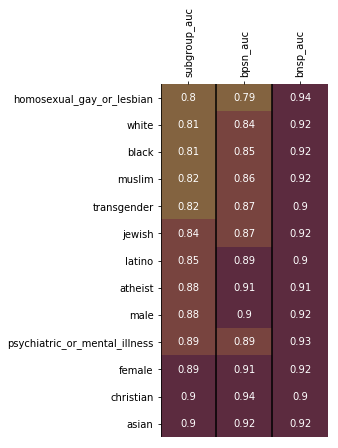

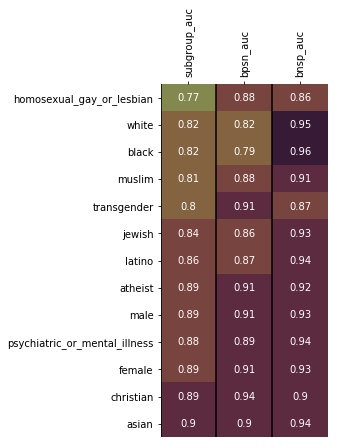

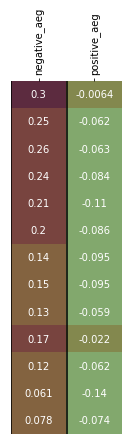

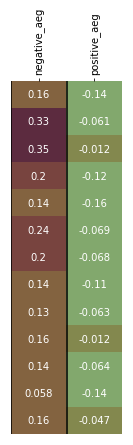

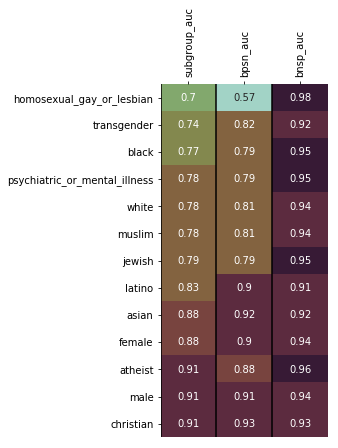

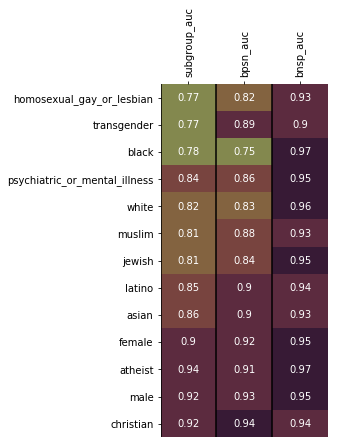

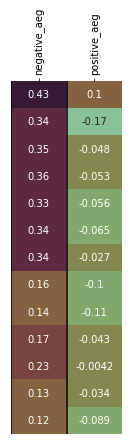

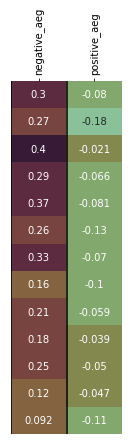

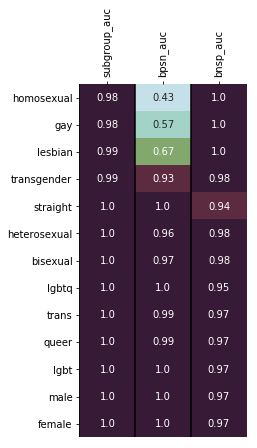

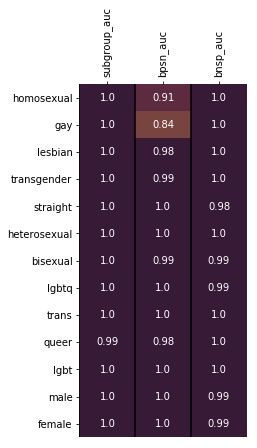

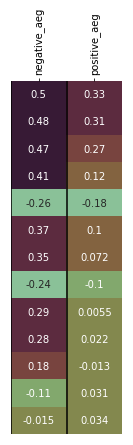

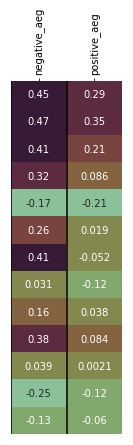

In [45]:
# Print Civil Comments heatmaps.  Filter identities to only use those which have >= 100
# short comments written about them.
CIVIL_COMMENTS_HEATMAP_IDENTITIES = get_identities_over_n(civil_comments_short_df, 100, civil_comments_identity_terms)
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_aucs_1.png')
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_aucs_6.png')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_aegs_1.png')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_aegs_6.png')

# Print Civil Comments Short Comments heatmaps
print_auc_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_short_aucs_1.png')
print_auc_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_short_aucs_6.png')
print_aeg_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_short_aegs_1.png')
print_aeg_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_short_aegs_6.png')

# Print Madlibs heatmaps, using same number of identities as civil comments
num_identities = len(CIVIL_COMMENTS_HEATMAP_IDENTITIES)
MADLIB_HEATMAP_IDENTITIES = madlibs_identity_terms[:num_identities]
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/madlibs_aucs_1.png')
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/madlibs_aucs_6.png')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/madlibs_aegs_1.png')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/madlibs_aegs_6.png')

In [15]:
# import latexipy as lp

# lp.latexify()  # Change to a serif font that fits with most LaTeX.

# with lp.figure('filename'):  # saves in img/ by default.
#     print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY')
